# Проект: вариант 2
## Задание 1. A/B–тестирование

### 1.1 Условие
Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные
В качестве входных данных мы имеем 4 csv-файла:<br>
- **groups** - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)<br>
- **groups_add** - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных<br>
- **active_studs** - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента<br>
- **checks** - файл с информацией об оплатах пользователей в дни проведения эксперимента.

### 1.3 Вопросы
- На какие метрики Вы смотрите в ходе анализа и почему?<br>
- Имеются ли различия в показателях и с чем они могут быть связаны?<br>
- Являются ли эти различия статистически значимыми?<br>
- Стоит ли запускать новую механику на всех пользователей?

### 1.4 Решение

#### 1. Импортируем библиотеки:

In [9]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from scipy.stats import norm, chi2_contingency

#### 2. Загрузим и посмотрим на данные:

In [13]:
groups = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/2qy7CsyVIBgN5A', sep=';')
groups_add = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/3aARY-P9pfaksg')
active_studs = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/V-gjQSYrGg_XVg')
checks = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/u_JMVBiAdm9fQA', sep=';')

In [3]:
groups.head(1)

id grp
0  1489   B

Посмотрим на размерность, количество ненулевый значений и типы данных:

In [6]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


Посмотрим на наличие/отсутсвие значений NULL или NA, т. е. пропущенных значений в наборе данных:

In [7]:
groups.isna().sum()

id     0
grp    0
dtype: int64

Проверим наличие дубликатов:

In [8]:
if groups[['id']].shape[0] < groups.shape[0]:
    print('В таблице "groups" есть дубликаты в колонке "id"')
else:
    print('В таблице "groups" дубликатов нет')

В таблице "groups" дубликатов нет


Проделываем тоже самое с таблицей "groups_add":

In [9]:
groups_add.head(1)

id grp
0  5694584   B

In [10]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [11]:
groups_add.isna().sum()

id     0
grp    0
dtype: int64

In [12]:
if groups_add[['id']].shape[0] < groups_add.shape[0]:
    print('В таблице "groups_add" есть дубликаты в колонке "id"')
else:
    print('В таблице "groups_add" дубликатов нет')

В таблице "groups_add" дубликатов нет


Проделываем тоже самое с таблицей "active_studs":

In [13]:
active_studs.head(1)

student_id
0      581585

In [14]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [15]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [16]:
if active_studs[['student_id']].shape[0] < active_studs.shape[0]:
    print('В таблице "active_studs" есть дубликаты в колонке "student_id"')
else:
    print('В таблице "active_studs" дубликатов нет')

В таблице "active_studs" дубликатов нет


И проделываем тоже самое с таблицей "checks":

In [53]:
checks.head(1)

id    rev
0  1627  990.0

In [18]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [19]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [20]:
if checks[['student_id']].shape[0] < checks.shape[0]:
    print('В таблице "checks" есть дубликаты в колонке "student_id"')
else:
    print('В таблице "checks" дубликатов нет')

В таблице "checks" дубликатов нет


#### 3. Подготовим  данные и проведем проверку на ошибки:
Объединим соответствующие таблицы и привоведем заголовки к одноименному виду:

In [14]:
active_studs.rename(columns={'student_id': 'id'}, inplace=True)
checks.rename(columns={'student_id': 'id'}, inplace=True)

In [15]:
full_group = pd.concat([groups, groups_add], ignore_index=True, axis=0)

Напишем условие, которое устранит возможное наличие задублированных данных:

In [23]:
if full_group["id"].nunique() < full_group.shape[0]:
    full_group = full_group.drop_duplicates(subset=["id", "grp"])
    print("Результат: найденные дубликаты были удалены")
else:
    print("Результат: дубликатов нет")

Результат: дубликатов нет


Проверим, что в "full_group" содержатся все студенты из "active_studs" и все студенты из "checks": 

In [24]:
if pd.merge(full_group, active_studs, how="inner").id.nunique() != active_studs.id.nunique():
    print('Ошибка: есть элементы из "active_studs", которых нет в "full_group"')
else:
    print('Проверка прошла успешно')

Проверка прошла успешно


In [25]:
if pd.merge(full_group, checks, how='inner').id.nunique() != checks.id.nunique():
    print('Ошибка: есть элементы из "checks", которых нет в "full_group"')
else:
    print('Проверка прошла успешно')

Проверка прошла успешно


Создадим новую колонку "involved_in_exp", которой будет информация заходил ли пользователь в дни эксперимента или нет ( 1 - Заходил, 0 - не заходил)

In [16]:
active_studs['involved_in_exp'] = 1

Объедим всю информвцию в один датафрейм:

In [17]:
full_group_merged = pd.merge(full_group, active_studs, how='left', on='id')
full_group_merged = pd.merge(full_group_merged, checks, how='left', on='id')
full_group_merged = full_group_merged.fillna(0)

In [11]:
full_group_merged

id grp  involved_in_exp    rev
0           1489   B              0.0    0.0
1           1627   A              1.0  990.0
2           1768   B              0.0    0.0
3           1783   B              0.0    0.0
4           1794   A              0.0    0.0
...          ...  ..              ...    ...
74571  200247820   B              0.0    0.0
74572  201032527   B              0.0    0.0
74573  201067612   B              0.0    0.0
74574  201067653   B              0.0    0.0
74575  201067659   B              0.0    0.0

[74576 rows x 4 columns]

#### Проверим наши данные на аномалии:

Проверим есть ли пользователи, которые оплатили курс в дни проведения эксперимента, но при этом в эти дни не заходили на платформу:

In [18]:
full_group_merged.query('involved_in_exp==0 & rev>0').shape[0]

149

Такие пользователи есть, теперь посчитаем их процент от общего числа оплативших:

In [13]:
fgm = full_group_merged
round((fgm.query('involved_in_exp==0 & rev>0').shape[0] * 100 / fgm.query('rev>0').shape[0]), 1)

27.5

Процент весомый, поэтому важно понять, учитывать ли этих пользователей в дальнейшем или нет. Для этого выясним причины. Что могло случиться?<br>
1. У платформы подписочная модель монетизация. Вывод: нельзя включать этих пользователей в дальнейшие расчеты.
2. Ошибка или технический сбой при сборе данных. Вывод: включаем этих пользователей в дальнейшие расчеты.
Предположим, что причина - сбой при сборе данных. Поэтому оставим этих пользователей.

In [40]:
full_group_merged.head()

id grp  involved_in_exp    rev  made_purchase
0  1489   B              0.0    0.0          False
1  1627   A              1.0  990.0           True
2  1768   B              0.0    0.0          False
3  1783   B              0.0    0.0          False
4  1794   A              0.0    0.0          False

In [32]:
full_group_merged.shape

(74576, 4)

#### 4. Выбор метрик.

Рассмотрим следующие метрики:<br>
- Средний чек
- ARPU - средний доход с пользователя (выручка за определенный период / количество активных пользователей за этот период)
- ARPPU - средний доход с платящего пользователя (выручка за определенный период / количество платящих пользователей за этот период)
- CR - конверсия в покупку (количество купивших пользователей / количество всех пользователей)

In [20]:
group_A = full_group_merged.query('grp=="A"')  # пользователи контрольной группы
group_B = full_group_merged.query('grp=="B"')  # пользователи целевой группы

In [21]:
group_A_in_exp = group_A.query('involved_in_exp==1')  # пользователи контрольной группы, участвующие в эксперименте
group_B_in_exp = group_B.query('involved_in_exp==1')  # пользователи целевой группы, участвующие в эксперименте

In [22]:
avg_check_A = group_A.query('rev>0').rev.dropna().mean()
avg_check_B = group_B.query('rev>0').rev.dropna().mean()

In [23]:
avg_check_A_in_exp = group_A_in_exp.query('rev>0').rev.dropna().mean()
avg_check_B_in_exp = group_B_in_exp.query('rev>0').rev.dropna().mean()

In [24]:
ARPU_A = group_A.rev.sum() / group_A.id.count()
ARPU_B = group_B.rev.sum() / group_B.id.count()

In [25]:
ARPU_A_in_exp = group_A_in_exp.rev.sum() / group_A_in_exp.id.count()
ARPU_B_in_exp = group_B_in_exp.rev.sum() / group_B_in_exp.id.count()

In [26]:
ARPPU_A = group_A.query('rev>0').rev.sum() / group_A.query('rev>0').id.count()
ARPPU_B = group_B.query('rev>0').rev.sum() / group_B.query('rev>0').id.count()

In [27]:
ARPPU_A_in_exp = group_A_in_exp.query('rev>0').rev.sum() / group_A_in_exp.query('rev>0').id.count()
ARPPU_B_in_exp = group_B_in_exp.query('rev>0').rev.sum() / group_B_in_exp.query('rev>0').id.count()

In [28]:
CR_A = group_A.query('rev>0').id.count() / group_A.id.count() * 100
CR_B = group_B.query('rev>0').id.count() / group_B.id.count() * 100

In [29]:
CR_A_in_exp = group_A_in_exp.query('rev>0').id.count() / group_A_in_exp.id.count() * 100
CR_B_in_exp = group_B_in_exp.query('rev>0').id.count() / group_B_in_exp.id.count() * 100

In [30]:
print('1. Cредний чек (avg_check): ')
print(f'Группа А: {round(avg_check_A,2)}\nГруппа Б: {round(avg_check_B,2)}')
print('Cредний чек в дни эксперимента (avg_check_in_exp): ')
print(f'Группа А: {round(avg_check_A_in_exp,2)}\nГруппа Б: {round(avg_check_B_in_exp,2)}')
print('\n')
print('2. Cредняя выручка на одного пользователя (ARPU): ')
print(f'Группа А: {round(ARPU_A,2)}\nГруппа Б: {round(ARPU_B,2)}')
print('Cредняя выручка на одного пользователя в дни эксперимента (ARPU_in_exp): ')
print(f'Группа А: {round(ARPU_A_in_exp,2)}\nГруппа Б: {round(ARPU_B_in_exp,2)}')
print('\n')
print('3. Cредняя выручка на одного платящего пользователя (ARPPU): ')
print(f'Группа А: {round(ARPPU_A,2)}\nГруппа Б: {round(ARPPU_B,2)}')
print('Cредняя выручка на одного платящего пользователя в дни эксперимента (ARPPU_in_exp): ')
print(f'Группа А: {round(ARPPU_A_in_exp,2)}\nГруппа Б: {round(ARPPU_B_in_exp,2)}')
print('\n')
print('4. Конверсия в покупку (CR): ')
print(f'Группа А: {round(CR_A,3)}\nГруппа Б: {round(CR_B,3)}')
print('Конверсия активных пользователей в покупку в дни эксперимента (CR_in_exp): ')
print(f'Группа А: {round(CR_A_in_exp,3)}\nГруппа Б: {round(CR_B_in_exp,3)}')

1. Cредний чек (avg_check): 
Группа А: 860.71
Группа Б: 1108.82
Cредний чек в дни эксперимента (avg_check_in_exp): 
Группа А: 933.59
Группа Б: 1257.88


2. Cредняя выручка на одного пользователя (ARPU): 
Группа А: 6.27
Группа Б: 8.04
Cредняя выручка на одного пользователя в дни эксперимента (ARPU_in_exp): 
Группа А: 47.35
Группа Б: 58.06


3. Cредняя выручка на одного платящего пользователя (ARPPU): 
Группа А: 860.71
Группа Б: 1108.82
Cредняя выручка на одного платящего пользователя в дни эксперимента (ARPPU_in_exp): 
Группа А: 933.59
Группа Б: 1257.88


4. Конверсия в покупку (CR): 
Группа А: 0.728
Группа Б: 0.725
Конверсия активных пользователей в покупку в дни эксперимента (CR_in_exp): 
Группа А: 5.072
Группа Б: 4.616


Видно, что средний чек и ARPPU равны. Причина в том, что пользователи совершили только по одной покупке. То есть метрики обозначают примерно одно и то же. Каждая в отдельности не содержит уникальной информации. Таким образом, целесообразно выбрать одну. Поэтому в дальнейшем будем опирать только на "средний чек".

#### 5. Определение и проверка гипотез.

Для правильной проверки той или иной гипотезы, важно выбрать правильный статистический метод. Для начала исследуем наши данные. После выберем метод.<br>
1) Посмотрим на распределение покупок в обеих группах:

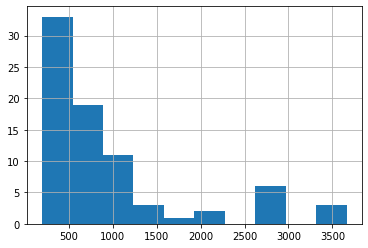

In [41]:
group_A_in_exp.query('rev>0').rev.dropna().hist()

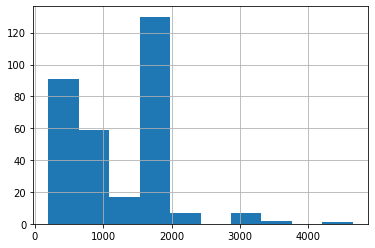

In [42]:
group_B_in_exp.query('rev>0').rev.dropna().hist()

Вывод: визуально видно, что наши данные распределены не нормально и не симметрично.

2) Исследуем выбросы:

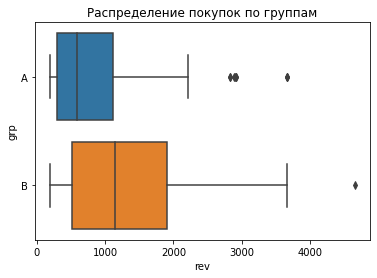

In [50]:
sns.boxplot(x="rev", y="grp", data=full_group_merged.query(
    'rev>0 & involved_in_exp==1'))
plt.title('Распределение покупок по группам')
plt.show()

In [51]:
print('Количество выбросов:\nГруппа А -', len(group_A_in_exp.query('rev>2400')))
print('Группа Б -', len(group_B_in_exp.query('rev>3700')))

Количество выбросов:
Группа А - 9
Группа Б - 1


Вывод: выбросов мало и их размер не значителен, поэтому они не повлияют на результат.

Итак, для сравнения средних чеков выберем метод Bootstrap. Этот метод хорошо работает с "не нормальными" распределениями и успешно сравнивает выборки разных размеров. Сформулируем гипотезы:
- H0 - разницы средних чеков в контрольной и целевой группах нет
- H1 - разница средних чеков в контрольной и целевой группах есть

                                     Применение Bootstrap с np.mean.

In [61]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

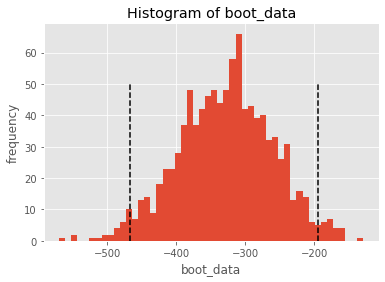

Значение p_value: 1.3649934704234914e-06


In [69]:
booted_data = get_bootstrap(group_A_in_exp.query(
    'rev>0').rev, group_B_in_exp.query('rev>0').rev)

print(f'Значение p_value: {booted_data["p_value"]}')

In [64]:
booted_data["ci"]

0
0.025 -446.322700
0.975 -191.270231

Таким образом, с помочью Bootstrap (с np.mean) получили p_value = 1.36e-06 и, что '0' не входит в доверительный интервал. Поэтому отвергаем нулевую гипотезу H0 (разницы средних чеков в контрольной и целевой группах нет).

                                    Применение Bootstrap с np.median.

In [71]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_itreplace = True=1000,  # количество бутстрэп-подвыборок
    statistic=np.median,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2))  # median() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.median(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.median(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

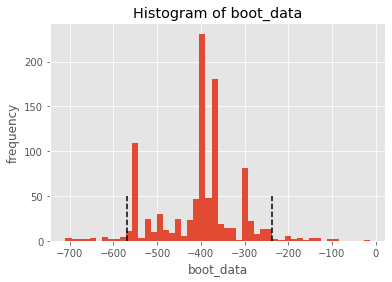

Значение p_value: 1.887535733006321e-05


In [75]:
booted_data = get_bootstrap(group_A_in_exp.query(
    'rev>0').rev, group_B_in_exp.query('rev>0').rev)

print(f'Значение p_value: {booted_data["p_value"]}')

Как видим, распределение массива "booted_data" не является нормальным, поэтому опираться на Bootstrap для медиан нельзя в данном случае. Поэтому оставляем вывод только на основании эксперимента Bootstrap для средних, сделанный выше.

                            Сравнение конверсий с помощью критерия Хи-квадрат.

Важно определить причину уменьшения конверсии в покупку у активных пользоваталей. Для этого воспользуемся критерием Хи-квадрат. Этот метод успешно применяется для определения взаимосвязи двух номинальных признаков. В нашем случае это группа (А или В) и совершение покупки (купил или не_купил), т.е. два бинарных (номинальных, не количественных) признака. Проверяется гипотеза, зависит ли вероятность совершения покупки от группы.
<br>Сформулируем гипотезы:<br>H0: Взаимосвязи между группами и количеством совершенных покупок нет<br>H1: Взаимосвязь между группами и количеством совершенных покупок есть

In [44]:
full_group_merged.head()

id grp  involved_in_exp    rev
0  1489   B              0.0    0.0
1  1627   A              1.0  990.0
2  1768   B              0.0    0.0
3  1783   B              0.0    0.0
4  1794   A              0.0    0.0

Создадим столбец 'made_purchase' и поместим туда информацию о том, покупал ли пользователь что-то на платформе или нет:

In [38]:
full_group_merged['made_purchase'] = full_group_merged.rev > 0
full_group_merged_in_exp = full_group_merged.query('involved_in_exp==1')
full_group_merged_in_exp

id grp  involved_in_exp    rev  made_purchase
1         1627   A              1.0  990.0           True
10        2085   B              1.0    0.0          False
12        2215   B              1.0    0.0          False
43        3391   A              1.0    0.0          False
45        3401   B              1.0    0.0          False
...        ...  ..              ...    ...            ...
74543  5760471   B              1.0    0.0          False
74545  5777081   B              1.0    0.0          False
74558  5870856   A              1.0    0.0          False
74561  5945085   B              1.0    0.0          False
74562  5951797   B              1.0    0.0          False

[8341 rows x 5 columns]

In [50]:
df_chi2 = pd.crosstab(full_group_merged_in_exp.grp, full_group_merged_in_exp.made_purchase)
df_chi2

made_purchase  False  True 
grp                        
A               1460     78
B               6489    314

In [51]:
chi2, prob, df, expected = chi2_contingency(df_chi2)

output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"

print(output.format(chi2, df, prob))

print(expected)

test Statistics: 0.48480826522557896
degrees of freedom: 1
p-value: 0.48625240457231045

[[1465.71897854   72.28102146]
 [6483.28102146  319.71897854]]


p_value > 0.05 значит оставляем нулевую гипотезу, что взаимосвязи между группами и количеством совершенных покупок нет.

# Выводы

1. Bootstrap показал наличие статистически значимых различий между средними чеками в исследуемых группах. Средний чек в экспериментальной группе больше на 34.7%.
2. Взаимосвязи между группами и количеством совершённых покупок нет. Это позволяет принебречь фактом, что CR пользователей в целевой группе уменьшился.
3. Таким образом, запускать новую механику целесообразно. Это увеличит средний чек, хотя конверсия в покупку не улучшиться.

## Задание 2. SQL

### 2.1 Очень усердные ученики.
### 2.1.1 Условие
Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин за час.

### 2.1.2 Задача
Дана таблица **peas**:<br>
- st_id - ID ученика <br>
- timest - Время решения карточки<br>
- correct - Правильно ли решена горошина?<br>
- subject - Дисциплина, в которой находится горошина<br>

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.<br>
Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

### 2.1.3 Решение<br>
    SELECT
        COUNT(DISTINCT st_id) AS diligent_students
    FROM
        (
        SELECT
            st_id,
            toDayOfMonth(timest) as day_of_month,
            toHour(timest) as hour_of_solve,
            SUM(correct) as correct_solutions
        FROM
            peas
        WHERE
            toStartOfMonth(timest) = '2020-03-01'
        GROUP BY
            st_id,
            day_of_month,
            hour_of_solve
        )
    WHERE
        correct_solutions >= 20

### 2.2 Оптимизация воронки

### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

### 2.2.2 Задача

Дана таблицы:<br>
**peas**:<br>
- st_id - ID ученика <br>
- timest - Время решения карточки<br>
- correct - Правильно ли решена горошина?<br>
- subject - Дисциплина, в которой находится горошина<br>

**studs:** <br>
- st_id - ID ученика<br>
- test_grp - Метка ученика в данном эксперименте<br>

**checks:** <br>
- st_id - ID ученика<br>
- sale_time - Время покупки<br>
- money - Цена, по которой приобрели данный курс<br>
- subject - Дисциплина, на которую приобрели полный доступ<br>

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:<br>
*ARPU* <br>
*ARPAU* <br>
*CR в покупку* <br>
*СR активного пользователя в покупку* <br>
*CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике*

### 2.2.3 Решение<br>
    SELECT
        r.test_grp as test_grp,
        round(revenue / all_users, 2) as ARPU,
        round(revenue / active_users, 2) as ARPAU,
        100 * paid_users / all_users as CR,
        100 * active_paid_users / active_users as CR_active_users,
        100* users_paid_math / users_math as CR_math
    FROM
        (
        SELECT
            b.test_grp as test_grp,
            SUM(a.money) as revenue
        FROM default.final_project_check AS a
        LEFT JOIN (
                    SELECT
                        DISTINCT st_id,
                        test_grp
                    FROM default.studs
                    ) as b
        ON a.st_id = b.st_id
        GROUP BY
            test_grp
        ) AS r -- Доходом по группам
        ------------
        LEFT JOIN (
                    SELECT
                        b.test_grp,
                        COUNT (DISTINCT st_id) as all_users
                    FROM default.peas as a
                    LEFT JOIN (
                            SELECT
                                DISTINCT (st_id),
                                test_grp
                            FROM default.studs    
                            ) as b
                    ON a.st_id = b.st_id
                    GROUP BY
                        test_grp
                    ) as h -- Все пользователи
        ON r.test_grp = h.test_grp
        ------------
        LEFT JOIN (
                    SELECT
                        b.test_grp as test_grp,
                        COUNT (DISTINCT st_id) as active_users
                    FROM default.peas as a
                    LEFT JOIN (
                            SELECT
                                DISTINCT (st_id),
                                test_grp
                            FROM default.studs    
                            ) as b
                    ON a.st_id = b.st_id
                    WHERE a.correct = 1
                    GROUP BY
                        b.test_grp
                    ) as k -- Активные пользователи (те, кто хотя бы 1 раз решил правильно задание)
        ON r.test_grp = k.test_grp
        ------------
        LEFT JOIN (
                    SELECT
                        b.test_grp as test_grp,
                        COUNT (DISTINCT st_id) as paid_users
                    FROM default.final_project_check as a
                    LEFT JOIN (
                            SELECT
                                DISTINCT (st_id),
                                test_grp
                            FROM default.studs    
                            ) as b
                    ON a.st_id = b.st_id
                    GROUP BY
                        b.test_grp
                    ) as p -- Пользователи, которые оплатили полный доступ
        ON r.test_grp = p.test_grp
        ------------
        LEFT JOIN (

                    SELECT c.test_grp as test_grp,
                           count (DISTINCT b.st_id) as active_paid_users
                    FROM default.peas as a 
                    LEFT JOIN default.final_project_check as b 
                    ON a.st_id = b.st_id and a.subject = b.subject
                    LEFT JOIN (
                                SELECT DISTINCT st_id,
                                           test_grp
                                FROM default.studs
                                ) as c
                    ON a.st_id = c.st_id 
                    WHERE a.correct = 1
                    GROUP BY c.test_grp

                    ) as ap -- Активные пользователи, которые оплатили полный доступ 
        ON r.test_grp = ap.test_grp
        ------------
        LEFT JOIN (
                SELECT c.test_grp as test_grp,
                       count (DISTINCT a.st_id) as users_math,
                       count (DISTINCT b.st_id) as users_paid_math
                FROM default.peas as a
                LEFT JOIN default.final_project_check as b 
                ON a.st_id = b.st_id AND a.subject = b.subject
                LEFT JOIN (
                            SELECT
                                DISTINCT st_id,
                                test_grp
                            FROM default.studs
                ) as c
                ON a.st_id = c.st_id
                WHERE a.subject = 'Math' 
                GROUP BY c.test_grp
            ) as m -- Пользователи, которые решали задачи по математике и купили потом курс по математике
        ON r.test_grp = m.test_grp

## Задание 3. Python
### 3.1 Задача

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

### 3.2 Решение

Создадим переменную link и поместим туда ссылку для скачивания дополнительного файла с пользователями

In [33]:
link = 'https://disk.yandex.ru/d/3aARY-P9pfaksg'
group_add_link = 'https://getfile.dokpub.com/yandex/get/' + link

In [34]:
def add_data(groups, group_add_link, active_studs, checks):
    # считываем данные из дополнительного файла
    group_add = pd.read_csv(group_add_link)
    
    # приведём соответствующие колонки к одноименному виду
    group_add.rename(columns={group_add.columns[0]: 'id', group_add.columns[1]: 'grp'}, inplace=True)
    active_studs.rename(columns={'student_id': 'id'}, inplace=True)
    checks.rename(columns={'student_id': 'id'}, inplace=True)

    # добавляем дополнительные данные к уже имеющимся
    full_group = pd.concat([groups, group_add], ignore_index=True, axis=0)
    full_group = full_group.drop_duplicates(subset=["id", "grp"])
    
    # формируем итоговый датафрейм с результатами эксперимента
    exp_group = active_studs \
        .merge(checks, how='left', on='id') \
        .merge(full_group, how='inner', on='id')
    exp_group['buy'] = exp_group.rev > 0
    
    # пересчитываем метрики
    metrics = exp_group \
        .groupby('grp', as_index=False) \
        .agg({'rev': 'sum'})
    
    clients = exp_group \
        .query('rev > 0') \
        .groupby('grp', as_index=False) \
        .agg({'id': 'count'}) \
        .rename(columns={'id': 'clients'})
    
    users = exp_group \
        .groupby('grp', as_index=False) \
        .agg({'id': 'count'}) \
        .rename(columns={'id': 'users'})
    metrics = metrics.merge(clients).merge(users)
    
    metrics['CR'] = 100 * metrics.clients / metrics.users
    metrics['avg_check'] = metrics.rev / metrics.clients
    metrics['ARPU'] = metrics.rev / metrics.users
    
    return metrics

In [41]:
metrics = add_data(full_group, group_add_link, active_studs, checks)
metrics

grp          rev  clients  users        CR    avg_check       ARPU
0   A   72820.0000       78   1538  5.071521   933.589744  47.347204
1   B  394974.0035      314   6803  4.615611  1257.878992  58.058798

In [36]:
def graphics(exp_group, metrics):
    
    # графики распределения покупок по группам
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    sns.histplot(exp_group.query('grp == "A" & rev > 0').rev, ax=axes[0], color='green')
    sns.histplot(exp_group.query('grp == "B" & rev > 0').rev, ax=axes[1], color='purple')
    axes[0].set(title='Покупки в группе А', xlabel='checks')
    axes[1].set(title='Покупки в группе B', xlabel='checks')
    
    # графики метрик по группам
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    sns.barplot(x='grp', y='avg_check', data=metrics, ax=axes[0], palette="Paired")
    axes[0].set(title='Средний чек', xlabel='groups')
    plt.tight_layout(w_pad=2)

    sns.barplot(x='grp', y='CR', data=metrics, ax=axes[1], palette="Paired")
    axes[1].set(title='Конверсия в покупку', xlabel='groups')

    sns.barplot(x='grp', y='ARPU', data=metrics, ax=axes[2], palette="Paired")
    axes[2].set(title='ARPU', xlabel='groups')
    
    plt.show()

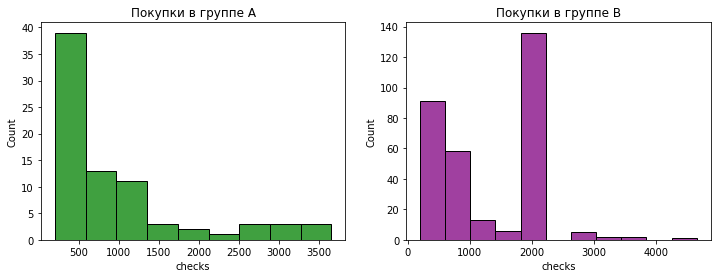

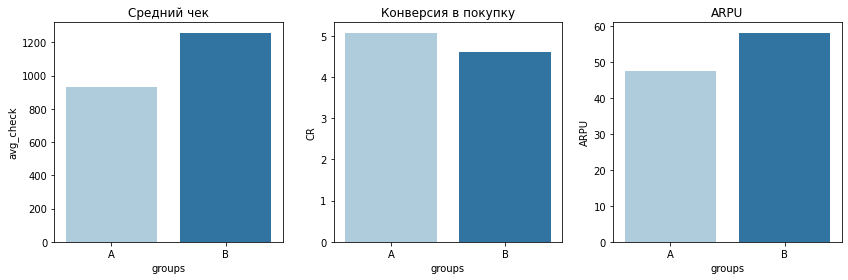

In [42]:
graphics(full_group_merged_in_exp, metrics)